## Importing libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # visualization library
plt.style.use('ggplot')
import seaborn as sns # visualization library
import scipy.stats as stats


In [128]:
#from google.colab import drive
#drive.mount("/content/gdrive")

In [2]:
# import data. Be careful for Date type, String type (factors in R).

train = pd.read_csv("Rossman_data_sales/train.csv", sep=',', parse_dates=['Date'],
                    dtype={'StateHoliday': str, 'SchoolHoliday':str})

test = pd.read_csv("Rossman_data_sales/test.csv", sep=",", index_col = 'Id', parse_dates=['Date'],
                  dtype={'StateHoliday': str, 'SchoolHoliday':str})

store = pd.read_csv("Rossman_data_sales/store.csv", sep=",", dtype={'StoreType': str,
                                                      'Assortment': str,
                                                      'PromoInterval': str})

In [3]:
# Inspecting train
print(train.head())

   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

  SchoolHoliday  
0             1  
1             1  
2             1  
3             1  
4             1  


## Data Anlaysis

## 1) Train Dataset

In [4]:
train.shape

(1017209, 9)

### Checking for the mean value for when the store is not open

In [5]:
train.loc[train['Open'] == 0, 'Sales'].mean()



0.0

### new columns Year and Month to be used in the analysis of seasonal effects on sales

In [6]:
train['Year'] = pd.DatetimeIndex(train['Date']).year
train['Month'] = pd.DatetimeIndex(train['Date']).month

### Train data Columns analysis 

In [7]:
train = train[['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Customers', 'Open',
               'Promo', 'StateHoliday', 'SchoolHoliday', 'Sales']]
list(train.columns.values)

['Store',
 'DayOfWeek',
 'Date',
 'Year',
 'Month',
 'Customers',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday',
 'Sales']

In [8]:
# Inspecting train data - Data types

train.dtypes

Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Year                      int64
Month                     int64
Customers                 int64
Open                      int64
Promo                     int64
StateHoliday             object
SchoolHoliday            object
Sales                     int64
dtype: object

In [9]:
# Unique values of "StateHoliday" factor

train['StateHoliday'].unique()

array(['0', 'a', 'b', 'c'], dtype=object)

In [10]:
# Factor levels: '0' -> 0 ; 'a' -> 1; 'b' -> 2; 'c' -> 3.
def factor_to_integer(df, colname, start_value=0):
    while df[colname].dtype == object:
        myval = start_value # factor starts at "start_value".
        for sval in df[colname].unique():
            df.loc[df[colname] == sval, colname] = myval
            myval += 1
        df[colname] = df[colname].astype(int, copy=False)
    print('levels :', df[colname].unique(), '; data type :', df[colname].dtype)


In [11]:
# Unique values of "SchoolHoliday" factor

train['SchoolHoliday'].unique()

array(['1', '0'], dtype=object)

In [12]:
factor_to_integer(train, 'SchoolHoliday')


levels : [0 1] ; data type : int32


### Statistical description of train data

In [13]:
print(train.describe())

              Store     DayOfWeek          Year         Month     Customers  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  2.013832e+03  5.846762e+00  6.331459e+02   
std    3.219087e+02  1.997391e+00  7.773960e-01  3.326097e+00  4.644117e+02   
min    1.000000e+00  1.000000e+00  2.013000e+03  1.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  2.013000e+03  3.000000e+00  4.050000e+02   
50%    5.580000e+02  4.000000e+00  2.014000e+03  6.000000e+00  6.090000e+02   
75%    8.380000e+02  6.000000e+00  2.014000e+03  8.000000e+00  8.370000e+02   
max    1.115000e+03  7.000000e+00  2.015000e+03  1.200000e+01  7.388000e+03   

               Open         Promo  SchoolHoliday         Sales  
count  1.017209e+06  1.017209e+06   1.017209e+06  1.017209e+06  
mean   8.301067e-01  3.815145e-01   8.213533e-01  5.773819e+03  
std    3.755392e-01  4.857586e-01   3.830564e-01  3.849926e+03  
min    0.000000e+00  0.00000

In [14]:
# Checking for Nan values
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : train[colname].isnull().sum() for colname in train.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Year', 0),
 ('Month', 0),
 ('Customers', 0),
 ('Open', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0),
 ('Sales', 0)]

In [15]:
#Compute pairwise correlation of columns using pandas.corr() function
corMat = pd.DataFrame(train.loc[:, ['DayOfWeek', 'Sales', 'Month', 'Year', 'Customers', 'Promo',
                                    'StateHoliday', 'SchoolHoliday']].corr())
print(corMat)


               DayOfWeek     Sales     Month      Year  Customers     Promo  \
DayOfWeek       1.000000 -0.462125 -0.005362  0.001937  -0.386445 -0.392925   
Sales          -0.462125  1.000000  0.048768  0.023519   0.894711  0.452345   
Month          -0.005362  0.048768  1.000000 -0.269382   0.038179 -0.011747   
Year            0.001937  0.023519 -0.269382  1.000000  -0.001212  0.024300   
Customers      -0.386445  0.894711  0.038179 -0.001212   1.000000  0.316169   
Promo          -0.392925  0.452345 -0.011747  0.024300   0.316169  1.000000   
SchoolHoliday   0.205388 -0.085124 -0.103282  0.036535  -0.071568 -0.067483   

               SchoolHoliday  
DayOfWeek           0.205388  
Sales              -0.085124  
Month              -0.103282  
Year                0.036535  
Customers          -0.071568  
Promo              -0.067483  
SchoolHoliday       1.000000  


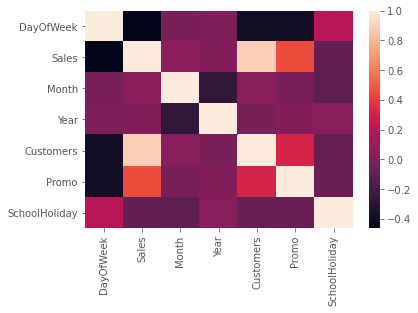

In [16]:
sns.heatmap(data=corMat)
plt.show()

## 2) Test Dataset

In [17]:
test.shape

(41088, 7)

In [18]:
test['Year'] = pd.DatetimeIndex(test['Date']).year
test['Month'] = pd.DatetimeIndex(test['Date']).month


### Number of closed store

In [19]:
sum(test['Open'] == 0)

5984

### Test data Columns analysis 

In [20]:
test = test[['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Open',
             'Promo', 'StateHoliday', 'SchoolHoliday']]
list(test.columns.values)

['Store',
 'DayOfWeek',
 'Date',
 'Year',
 'Month',
 'Open',
 'Promo',
 'StateHoliday',
 'SchoolHoliday']

In [21]:
#Checking for the Nan values
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : test[colname].isnull().sum() for colname in test.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Open', 11),
 ('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Year', 0),
 ('Month', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0)]

In [22]:
print(test.loc[np.isnan(test['Open'])])

       Store  DayOfWeek       Date  Year  Month  Open  Promo StateHoliday  \
Id                                                                          
480      622          4 2015-09-17  2015      9   NaN      1            0   
1336     622          3 2015-09-16  2015      9   NaN      1            0   
2192     622          2 2015-09-15  2015      9   NaN      1            0   
3048     622          1 2015-09-14  2015      9   NaN      1            0   
4760     622          6 2015-09-12  2015      9   NaN      0            0   
5616     622          5 2015-09-11  2015      9   NaN      0            0   
6472     622          4 2015-09-10  2015      9   NaN      0            0   
7328     622          3 2015-09-09  2015      9   NaN      0            0   
8184     622          2 2015-09-08  2015      9   NaN      0            0   
9040     622          1 2015-09-07  2015      9   NaN      0            0   
10752    622          6 2015-09-05  2015      9   NaN      0            0   

### Avoid missing any information. So deleting the rows of Store 622 which have missing Open value, should be our last option. Either label it 0 or 1. As seen above, we have data for Store 622 in train dataset. Therefore, let’s label missing values of Open column in test dataset as 1.

In [23]:
test.loc[np.isnan(test['Open']), 'Open'] = 1
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : test[colname].isnull().sum() for colname in test.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('DayOfWeek', 0),
 ('Date', 0),
 ('Year', 0),
 ('Month', 0),
 ('Open', 0),
 ('Promo', 0),
 ('StateHoliday', 0),
 ('SchoolHoliday', 0)]

### Checking for test data type

In [24]:
print(test.dtypes)

#We have one state holiday in this dataset:

test['StateHoliday'].unique()



Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Year                      int64
Month                     int64
Open                    float64
Promo                     int64
StateHoliday             object
SchoolHoliday            object
dtype: object


array(['0', 'a'], dtype=object)

In [25]:
#We have one school holiday in this dataset:

test['SchoolHoliday'].unique()

array(['0', '1'], dtype=object)

In [26]:
factor_to_integer(test, 'StateHoliday')
factor_to_integer(test, 'SchoolHoliday')
test.dtypes

levels : [0 1] ; data type : int32
levels : [0 1] ; data type : int32


Store                     int64
DayOfWeek                 int64
Date             datetime64[ns]
Year                      int64
Month                     int64
Open                    float64
Promo                     int64
StateHoliday              int32
SchoolHoliday             int32
dtype: object

## 3) Store data

In [27]:
print(store.shape)

print(store.head())

(1115, 10)
   Store StoreType Assortment  CompetitionDistance  CompetitionOpenSinceMonth  \
0      1         c          a               1270.0                        9.0   
1      2         a          a                570.0                       11.0   
2      3         a          a              14130.0                       12.0   
3      4         c          c                620.0                        9.0   
4      5         a          a              29910.0                        4.0   

   CompetitionOpenSinceYear  Promo2  Promo2SinceWeek  Promo2SinceYear  \
0                    2008.0       0              NaN              NaN   
1                    2007.0       1             13.0           2010.0   
2                    2006.0       1             14.0           2011.0   
3                    2009.0       0              NaN              NaN   
4                    2015.0       0              NaN              NaN   

     PromoInterval  
0              NaN  
1  Jan,Apr,Jul,Oct  


In [28]:
#Checking for the missing values
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store[colname].isnull().sum() for colname in store.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Promo2SinceWeek', 544),
 ('Promo2SinceYear', 544),
 ('PromoInterval', 544),
 ('CompetitionOpenSinceMonth', 354),
 ('CompetitionOpenSinceYear', 354),
 ('CompetitionDistance', 3),
 ('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('Promo2', 0)]

### Promo2SinceWeek, Promo2Interval, Promo2SinceYear, CompetitionOpenSinceMonth, CompetitionOpenSinceYear and CompetitionDistance columns have different size of missing values.

In [29]:
store['PromoInterval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

### Without promotion below rows will be zero

In [30]:
store.loc[store['Promo2'] == 0, ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']] = 0

store.loc[store['Promo2'] != 0, 'Promo2SinceWeek'] = store['Promo2SinceWeek'].max() - store.loc[store['Promo2'] != 0, 'Promo2SinceWeek']

store.loc[store['Promo2'] != 0, 'Promo2SinceYear'] = store['Promo2SinceYear'].max() - store.loc[store['Promo2'] != 0, 'Promo2SinceYear']

factor_to_integer(store, 'PromoInterval', start_value=0)

levels : [0 1 2 3] ; data type : int32


### Check the data types.

In [31]:
#Check the data types

store.dtypes

Store                          int64
StoreType                     object
Assortment                    object
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int32
dtype: object

In [32]:
factor_to_integer(store, 'StoreType')
factor_to_integer(store, 'Assortment')
store.dtypes

levels : [0 1 2 3] ; data type : int32
levels : [0 1 2] ; data type : int32


Store                          int64
StoreType                      int32
Assortment                     int32
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                  int32
dtype: object

In [33]:
#Agian checking for missing values
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store[colname].isnull().sum() for colname in store.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('CompetitionOpenSinceMonth', 354),
 ('CompetitionOpenSinceYear', 354),
 ('CompetitionDistance', 3),
 ('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('Promo2', 0),
 ('Promo2SinceWeek', 0),
 ('Promo2SinceYear', 0),
 ('PromoInterval', 0)]

In [34]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')


imputer = SimpleImputer().fit(store)
store_imputed = imputer.transform(store)

store2 = pd.DataFrame(store_imputed, columns=store.columns.values)

In [35]:
print("NANs for individual columns")
print("---------------------------")
from collections import Counter
x = {colname : store2[colname].isnull().sum() for colname in store2.columns}
Counter(x).most_common()

NANs for individual columns
---------------------------


[('Store', 0),
 ('StoreType', 0),
 ('Assortment', 0),
 ('CompetitionDistance', 0),
 ('CompetitionOpenSinceMonth', 0),
 ('CompetitionOpenSinceYear', 0),
 ('Promo2', 0),
 ('Promo2SinceWeek', 0),
 ('Promo2SinceYear', 0),
 ('PromoInterval', 0)]

In [36]:
store2.head()


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1.0,0.0,0.0,1270.0,9.0,2008.0,0.0,0.0,0.0,0.0
1,2.0,1.0,0.0,570.0,11.0,2007.0,1.0,37.0,5.0,1.0
2,3.0,1.0,0.0,14130.0,12.0,2006.0,1.0,36.0,4.0,1.0
3,4.0,0.0,1.0,620.0,9.0,2009.0,0.0,0.0,0.0,0.0
4,5.0,1.0,0.0,29910.0,4.0,2015.0,0.0,0.0,0.0,0.0


### Now after replacing the Nan values with the mean of the columns there are no missing values 

In [37]:
store2['CompetitionOpenSinceMonth'] = store2['CompetitionOpenSinceMonth'].max() - store2['CompetitionOpenSinceMonth']

store2['CompetitionOpenSinceYear'] = store2['CompetitionOpenSinceYear'].max() - store2['CompetitionOpenSinceYear']

#checking if the train data and store data similarity
len(store2['Store']) - sum(store2['Store'].isin(train['Store']))


0

## Data Pre-Processing

In [38]:
# Checking if there are additional (unnecessary) stores in "train" data.
# No difference at all!

StoreStore = pd.Series(store2['Store']); StoreTrain = pd.Series(train['Store'])

sum(StoreTrain.isin(StoreStore) == False)

0

In [39]:
#Merge train and store datasets before modeling the data.

train_store = pd.merge(train, store2, how = 'left', on='Store')

print(train_store.head())

   Store  DayOfWeek       Date  Year  Month  Customers  Open  Promo  \
0      1          5 2015-07-31  2015      7        555     1      1   
1      2          5 2015-07-31  2015      7        625     1      1   
2      3          5 2015-07-31  2015      7        821     1      1   
3      4          5 2015-07-31  2015      7       1498     1      1   
4      5          5 2015-07-31  2015      7        559     1      1   

  StateHoliday  SchoolHoliday  Sales  StoreType  Assortment  \
0            0              0   5263        0.0         0.0   
1            0              0   6064        1.0         0.0   
2            0              0   8314        1.0         0.0   
3            0              0  13995        0.0         1.0   
4            0              0   4822        1.0         0.0   

   CompetitionDistance  CompetitionOpenSinceMonth  CompetitionOpenSinceYear  \
0               1270.0                        3.0                       7.0   
1                570.0              

In [40]:
#Merge test and store datasets and check the result.

test_store = test.reset_index().merge(store2, how = 'left', on='Store').set_index('Id')

print(test_store.head())

    Store  DayOfWeek       Date  Year  Month  Open  Promo  StateHoliday  \
Id                                                                        
1       1          4 2015-09-17  2015      9   1.0      1             0   
2       3          4 2015-09-17  2015      9   1.0      1             0   
3       7          4 2015-09-17  2015      9   1.0      1             0   
4       8          4 2015-09-17  2015      9   1.0      1             0   
5       9          4 2015-09-17  2015      9   1.0      1             0   

    SchoolHoliday  StoreType  Assortment  CompetitionDistance  \
Id                                                              
1               0        0.0         0.0               1270.0   
2               0        1.0         0.0              14130.0   
3               0        1.0         1.0              24000.0   
4               0        1.0         0.0               7520.0   
5               0        1.0         1.0               2030.0   

    CompetitionOpe

In [41]:
print(test_store.shape)

test_store.isnull().sum()


(41088, 18)


Store                        0
DayOfWeek                    0
Date                         0
Year                         0
Month                        0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

## Data Visualisation

### Figure: Sales by Year


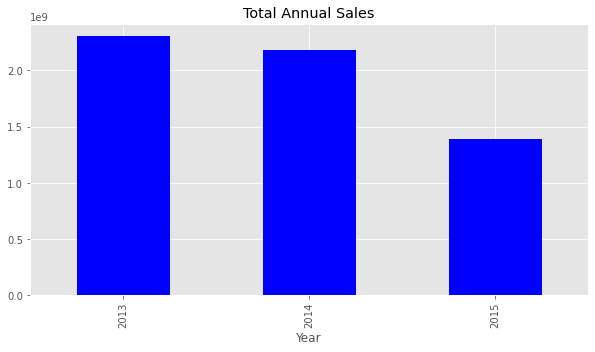

In [42]:
#Visual Exploration
#train_store.barplot(column='Sales', by='Year')
f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("Year")["Sales"].sum().plot(kind = "bar",color="blue", title = "Total Annual Sales")
plt.show()

### Figure: Sales by month

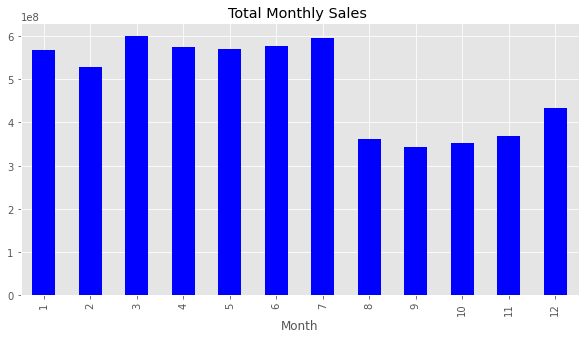

In [43]:
#train_store.boxplot(column='Sales', by='Month')
#plt.show()

f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("Month")["Sales"].sum().plot(kind = "bar",color="blue", title = "Total Monthly Sales ")
plt.show()

### Figure: Sales in state holidays

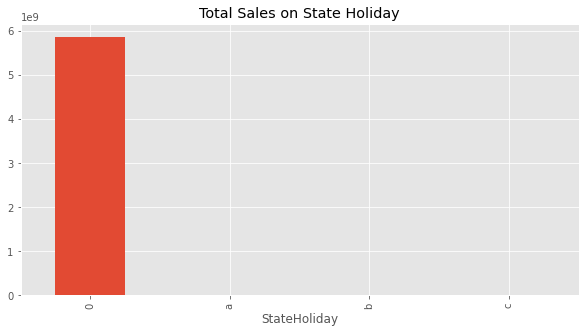

In [44]:
#train_store.boxplot(column='Sales', by='StateHoliday')
#plt.show()

f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("StateHoliday")["Sales"].sum().plot(kind = "bar", title = "Total Sales on State Holiday")
plt.show()

### Figure: Sales in school holidays

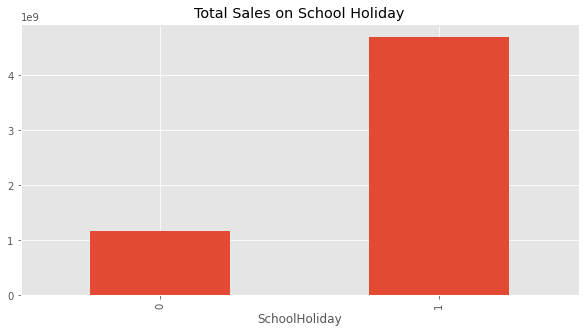

In [45]:
#train_store.boxplot(column='Sales', by='SchoolHoliday')
#plt.show()

f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("SchoolHoliday")["Sales"].sum().plot(kind = "bar", title = "Total Sales on School Holiday")
plt.show()

### Figure: Sales by store type

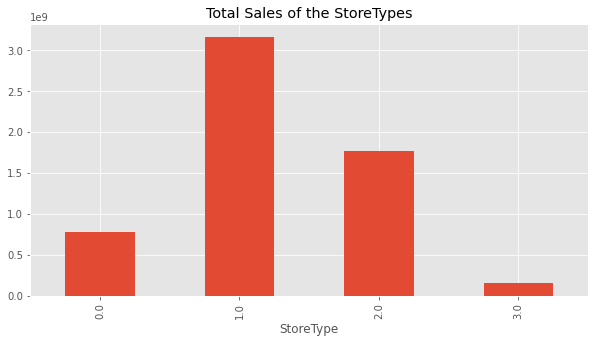

In [46]:
#train_store.boxplot(column='Sales', by='StoreType')
#plt.show()

f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("StoreType")["Sales"].sum().plot(kind = "bar", title = "Total Sales of the StoreTypes")
plt.show()

### Figure: Sales change through the week

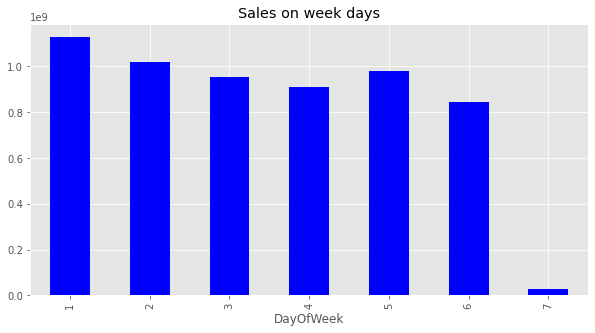

In [47]:
#train_store.boxplot(column='Sales', by='DayOfWeek')
#plt.show()

f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("DayOfWeek")["Sales"].sum().plot(kind = "bar",color="blue", title = "Sales on week days")
plt.show()

### Figure: Sales and promo

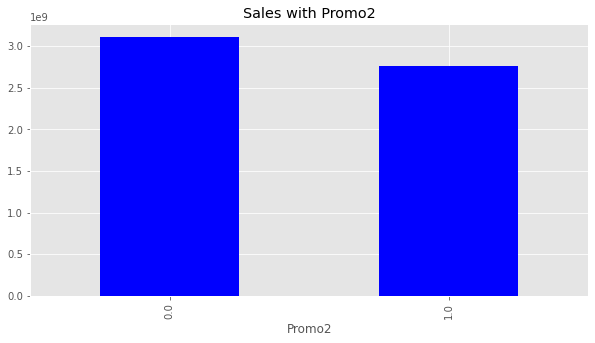

In [48]:
#train_store.boxplot(column='Sales', by='Promo2')
#plt.show()

f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("Promo2")["Sales"].sum().plot(kind = "bar",color="blue", title = "Sales with Promo2")
plt.show()

### Figure: Promo and Sales change

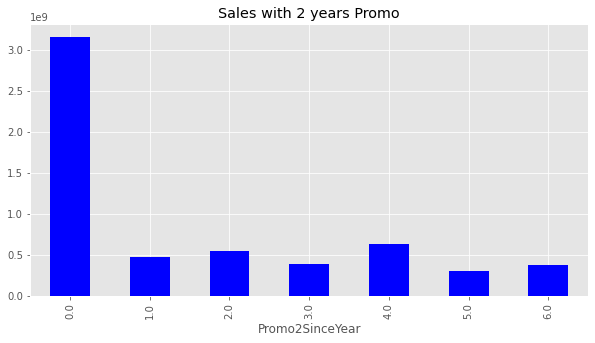

In [49]:
#train_store.loc[train['Promo'] != 0].boxplot(column='Sales', by='Promo2SinceYear')
#plt.show()

f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("Promo2SinceYear")["Sales"].sum().plot(kind = "bar",color="blue", title = "Sales with 2 years Promo")
plt.show()

### Figure: Monthly change in number of customers

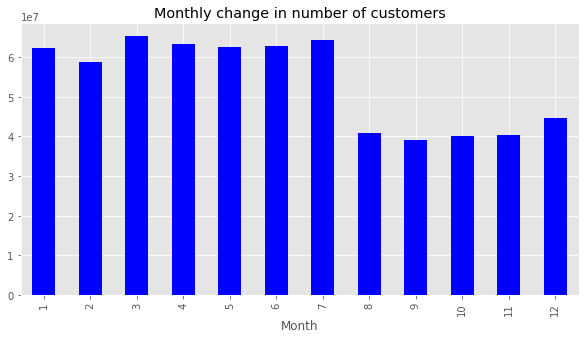

In [50]:
#train_store.boxplot(column='Customers', by='Month')
#plt.show()

f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("Month")["Customers"].sum().plot(kind = "bar",color="blue", title = "Monthly change in number of customers")
plt.show()

### Figure: Promo interval vs sales

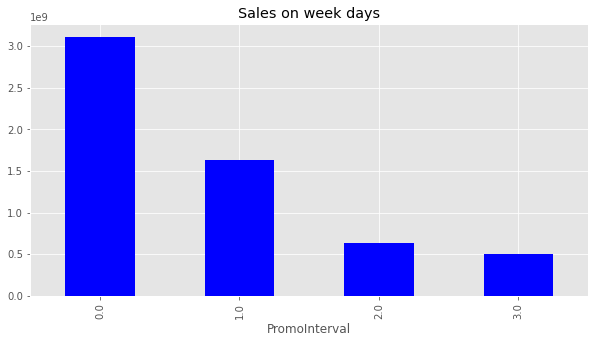

In [51]:
#train_store.loc[train['Promo'] != 0].boxplot(column='Sales', by='PromoInterval')
#plt.show()

f, ax = plt.subplots(1, 1, figsize = (10,5))
train_store.groupby("PromoInterval")["Sales"].sum().plot(kind = "bar",color="blue", title = "Sales on week days")
plt.show()

### Figure: Sales & years

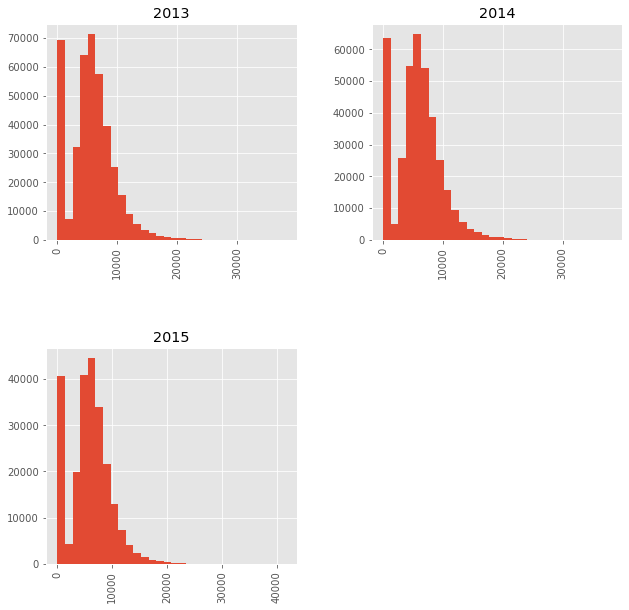

In [52]:
train_store.hist(column='Sales', by='Year', bins=30, figsize = (10,10))
plt.show()

### Figure: Sales & Months

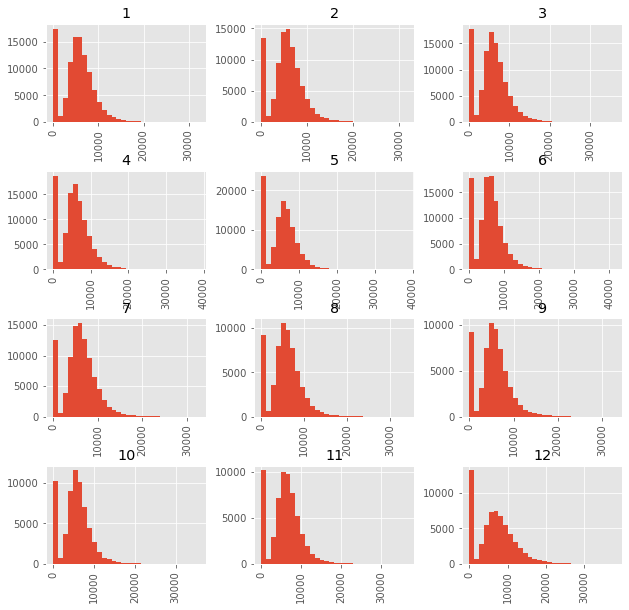

In [53]:
train_store.hist(column='Sales', by='Month', bins=30, figsize = (10,10))
plt.show()

### Figure: Effect of distance of the nearest store

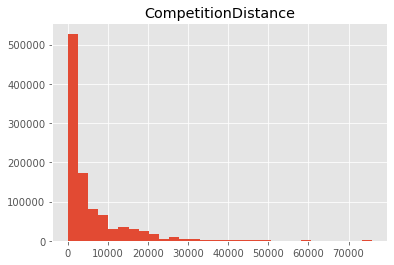

In [54]:
train_store.hist(column='CompetitionDistance', bins=30)
plt.show()

## Feature Importance

In [55]:
display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Year             0
Month            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Sales            0
dtype: int64

Store            0
DayOfWeek        0
Date             0
Year             0
Month            0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek                0
Promo2SinceYear                0
PromoInterval                  0
dtype: int64

In [56]:
store[pd.isnull(store.CompetitionOpenSinceMonth)].head(10)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,1,1,1070.0,NaN,NaN,1,37.0,5.0,1
12,13,2,0,310.0,NaN,NaN,1,5.0,6.0,2
15,16,1,1,3270.0,NaN,NaN,0,0.0,0.0,0
18,19,1,1,3240.0,NaN,NaN,1,28.0,4.0,3
21,22,1,0,1040.0,NaN,NaN,1,28.0,3.0,1
25,26,2,0,2300.0,NaN,NaN,0,0.0,0.0,0
28,29,2,1,2170.0,NaN,NaN,0,0.0,0.0,0
31,32,1,0,2910.0,NaN,NaN,1,5.0,6.0,2
39,40,1,0,180.0,NaN,NaN,1,5.0,6.0,2
40,41,2,1,1180.0,NaN,NaN,1,19.0,2.0,1


In [57]:
NoPW = store[pd.isnull(store.Promo2SinceWeek)]
NoPW[NoPW.Promo2 != 0].shape

(0, 10)

### 
The dataset contains the values f Sales which are 0 due to School or State Holiday.
Plot the train data having sales greater then 0 for Store1
It can be seen the sales jumps during end of Decemeber each year

<AxesSubplot:title={'center':'Store1'}, xlabel='Date'>

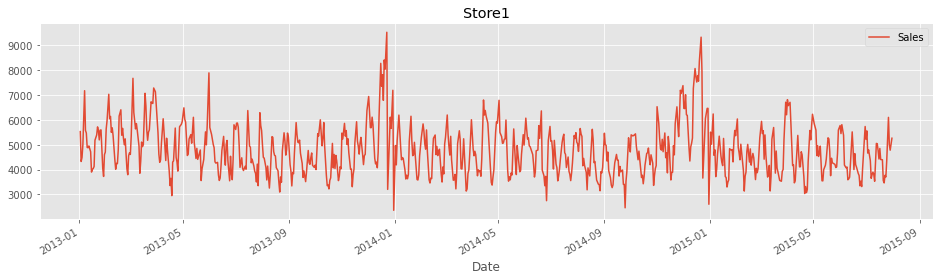

In [58]:
# sales of store1 full timne
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(16,4))

### Compare the Sles of Store 1 from 1st June 2016 to 31st July 2014 vs 1st August 2014 - 30th Sept 2014

<AxesSubplot:title={'center':'Store1'}, xlabel='Date'>

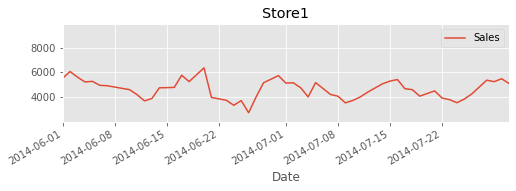

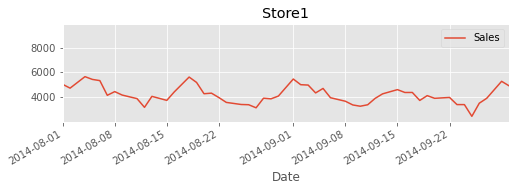

In [59]:
strain = train[train.Sales>0]
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-6-1','2014-7-31'])
strain.loc[strain['Store']==1 ,['Date','Sales']].plot(x='Date',y='Sales',title='Store1',figsize=(8,2),xlim=['2014-8-1','2014-9-30'])

In [60]:
#  null values are replaced and now we can moveahead with our analysis
# the store should be open in the test,so we fillna with 1
test.fillna(1, inplace=True)


# fillna in store with 0 has better result than median()
store.fillna(0, inplace=True)

display(train.isnull().sum(),test.isnull().sum(),store.isnull().sum())

Store            0
DayOfWeek        0
Date             0
Year             0
Month            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
Sales            0
dtype: int64

Store            0
DayOfWeek        0
Date             0
Year             0
Month            0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

Store                        0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

In [61]:
train1 = train
train1.head()

,Store,DayOfWeek,Date,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales
0,1,5,2015-07-31,2015,7,555,1,1,0,0,5263
1,2,5,2015-07-31,2015,7,625,1,1,0,0,6064
2,3,5,2015-07-31,2015,7,821,1,1,0,0,8314
3,4,5,2015-07-31,2015,7,1498,1,1,0,0,13995
4,5,5,2015-07-31,2015,7,559,1,1,0,0,4822


In [62]:
train2 = pd.merge(train1, store, on='Store')    ## for TimeSeries Arima Model
train2.columns

Index(['Store', 'DayOfWeek', 'Date', 'Year', 'Month', 'Customers', 'Open',
       'Promo', 'StateHoliday', 'SchoolHoliday', 'Sales', 'StoreType',
       'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

## Feature Selection

In [63]:
df_train_store = pd.merge(train, store, on='Store')   ## for XGBoost model
df_test_store = pd.merge(test, store, on='Store')

# Merge the training dataset with the Store dataset Merge the Test dataset with store dataset
train2['Sales/Customer'] = train2['Sales']/train2['Customers']
train2['Sales/Customer'].describe()

df_train_store['Sales/Customer'] = df_train_store['Sales']/df_train_store['Customers']

In [64]:
def features_create(data):
    
    
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)
    
    
    data['Year'] = data.Date.dt.year
    data['Month'] = data.Date.dt.month
    data['Day'] = data.Date.dt.day
    data['DayOfWeek'] = data.Date.dt.dayofweek
    data['WeekOfYear'] = data.Date.dt.weekofyear
    
    
    
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) +         (data.Month - data.CompetitionOpenSinceMonth)
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) +         (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['CompetitionOpen'] = data.CompetitionOpen.apply(lambda x: x if x > 0 else 0)        
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    
    
  
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',              7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

<AxesSubplot:>

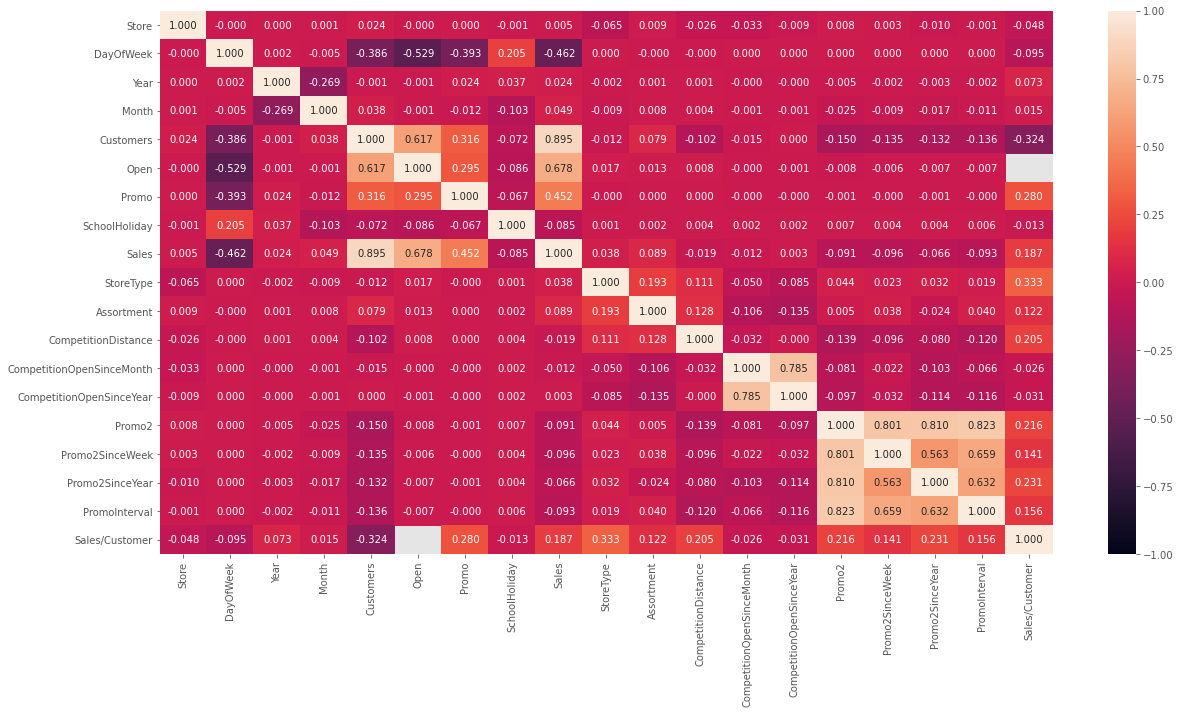

In [65]:
plt.figure(figsize = (20, 10))

sns.heatmap(df_train_store.corr(), annot = True, vmin = -1, vmax = 1, fmt = '.3f')

## Time Series Analysis

### Time-Series Analysis per Store Type

In Time Series, the data changes with the time. With an increasing or decreasing trend, most time series have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, for Christmas holidays, which we will see in this dataset.

In [66]:
train2 = train2.set_index('Date')
train2.head()

,Store,DayOfWeek,Year,Month,Customers,Open,Promo,StateHoliday,SchoolHoliday,Sales,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Sales/Customer
Date,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,555,1,1,0,0,5263,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,9.482883
2015-07-30,1,4,2015,7,546,1,1,0,0,5020,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,9.194139
2015-07-29,1,3,2015,7,523,1,1,0,0,4782,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,9.143403
2015-07-28,1,2,2015,7,560,1,1,0,0,5011,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,8.948214
2015-07-27,1,1,2015,7,612,1,1,0,0,6102,0,0,1270.0,9.0,2008.0,0,0.0,0.0,0,9.970588


### For Time Series Anlaysis , we consider one store from each store type a , b , c ,d

In [67]:
train2['Sales'] = train2['Sales'] * 1.0

sales_a = train2[train2.Store == 2]['Sales']
sales_b = train2[train2.Store == 85]['Sales'].sort_index(ascending = True) # solve the reverse order
sales_c = train2[train2.Store == 1]['Sales']
sales_d = train2[train2.Store == 13]['Sales']

### plot the sales of each store on Weekly basis

<AxesSubplot:xlabel='Date'>

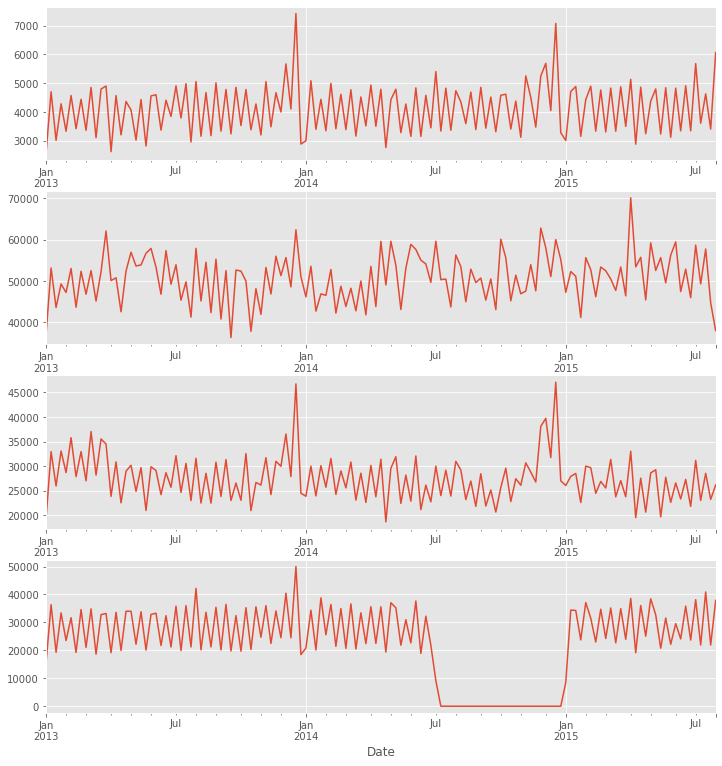

In [68]:
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, figsize = (12, 13))

# store types
sales_a.resample('W').mean().plot(ax = ax1)
sales_b.resample('W').sum().plot(ax = ax2)
sales_c.resample('W').sum().plot(ax = ax3)
sales_d.resample('W').sum().plot(ax = ax4)


Stationarity of Time Series

Lets check the stationarity through Dicky-Fulller and Rolling window technique:

We check the trend of sales for 1 store from each StoreType nd plot the data on Weekly basis,we can see that the trend is Stationary .i.e ; Constant mean Constant Variance, Covariance changes with time

Rolling: A rolling analysis of a time series model is often used to assess the model's stability over time. When analyzing financial time series data using a statistical model, a key assumption is that the parameters of the model are constant over time.

The window is rolled on Weekly basis , in which the average is taken on weekly basis Rolling Statistics is a visualization test , where we can compare the original data with the rolled data and check if the data is stationary or not

In [69]:
rollmean = sales_a.rolling(window=7).mean()
rollstd = sales_a.rolling(window=7).std()

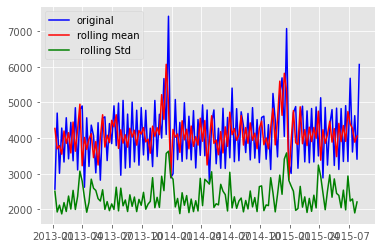

In [70]:
# data is resampled on weekly basis and plotted
orig = plt.plot(sales_a.resample('W').mean(),color='blue',label='original')
roll_mean = plt.plot(rollmean.resample('W').mean(),color='red',label='rolling mean')
orig_std = plt.plot(rollstd.resample('W').mean(),color='green',label=' rolling Std')
plt.legend(loc='best')
plt.show(block=False)

Dicky - Fuller test It is the test which essentially provides the details whether the Null hypothesis(Data is not stationary) should be rejected against alternate hypothesis(Data is stationary) It gives the Statistical measures explaining the ADF-Statistics value which should be less than the critical values we accept / reject the null hypothesis based on the p-value p-value < 0.5 indicates that the null hypothesis should be rejected

Thus from our data it is clear that our data is stationary and doesnot change heavily with time.

The Akaike information criterion (AIC) : It is an estimator of the relative quality of statistical models for a given set of data. Given a collection of models for the data, AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.

ADF statistics should be less than the critical interval

In [71]:
from statsmodels.tsa.stattools import adfuller
def stationary_check(sales):
  result = adfuller(sales,autolag='AIC')
  print('ADF Statistic: %f' % result[0])
  print('p-value: %f' % result[1])
  print('Critical Values:')
  for key, value in result[4].items():
	   print(key, value)

In [72]:
print("--------------------------------------------------------")
print("sales_a")
stationary_check(sales_a)

print("--------------------------------------------------------")
print("sales_b")
stationary_check(sales_b)

print("--------------------------------------------------------")
print("sales_c")
stationary_check(sales_c)

print("--------------------------------------------------------")
print("sales_d")
stationary_check(sales_d)

--------------------------------------------------------
sales_a
ADF Statistic: -6.218237
p-value: 0.000000
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
--------------------------------------------------------
sales_b
ADF Statistic: -5.660918
p-value: 0.000001
Critical Values:
1% -3.437485646962348
5% -2.8646901138095378
10% -2.568447319459459
--------------------------------------------------------
sales_c
ADF Statistic: -4.374784
p-value: 0.000329
Critical Values:
1% -3.4374778690219956
5% -2.864686684217556
10% -2.5684454926748583
--------------------------------------------------------
sales_d
ADF Statistic: -6.237461
p-value: 0.000000
Critical Values:
1% -3.4392539652094154
5% -2.86546960465041
10% -2.5688625527782327


If the test statistic is less than the critical value, we fail to reject the null hypothesis and we say series is stationary

If Time is Series is not Stationary

Below are the steps that can be performed to make a timeseries stationary

Take the log of data(Sales) Calcualte Moving Avergae = Log of data - Rolling value of log data Calculate weighted avergate = log of data - exponential of log data

### Decomposition Plots :

In [73]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [74]:
def plot_timeseries(sales,StoreType):

    fig, axes = plt.subplots(3, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    decomposition= seasonal_decompose(sales, model = 'additive',freq=360)

    estimated_trend = decomposition.trend
    estimated_seasonal = decomposition.seasonal
    estimated_residual = decomposition.resid



    axes[0].plot(estimated_trend, label='Trend')
    axes[0].legend(loc='upper left');

    axes[1].plot(estimated_seasonal, 'g', label='Seasonality')
    axes[1].legend(loc='upper left');

    axes[2].plot(estimated_residual, 'r', label='Residuals')
    axes[2].legend(loc='upper left')

    plt.title('Decomposition for StoreType')

<ipython-input-74-35302a60f4da>:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition= seasonal_decompose(sales, model = 'additive',freq=360)


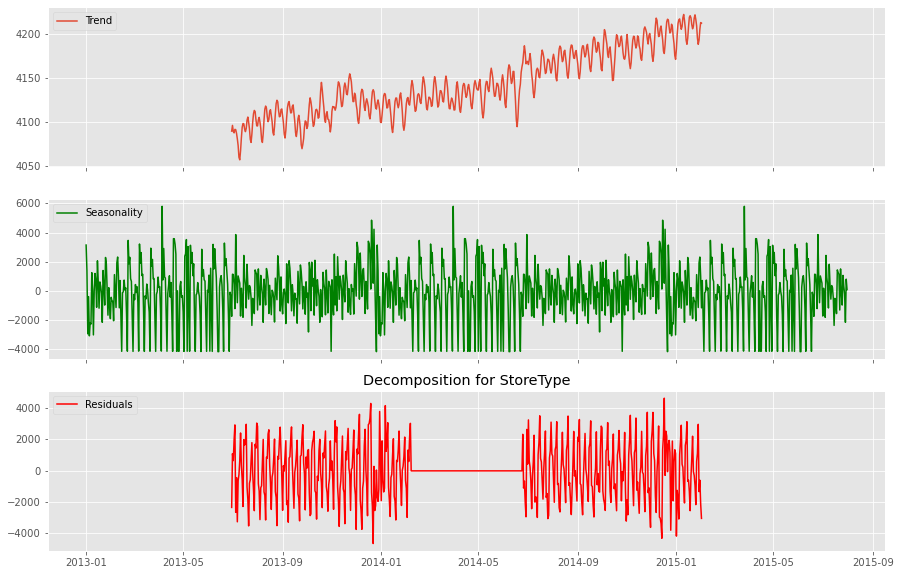

In [75]:
plot_timeseries(sales_a,'a')

<ipython-input-74-35302a60f4da>:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition= seasonal_decompose(sales, model = 'additive',freq=360)


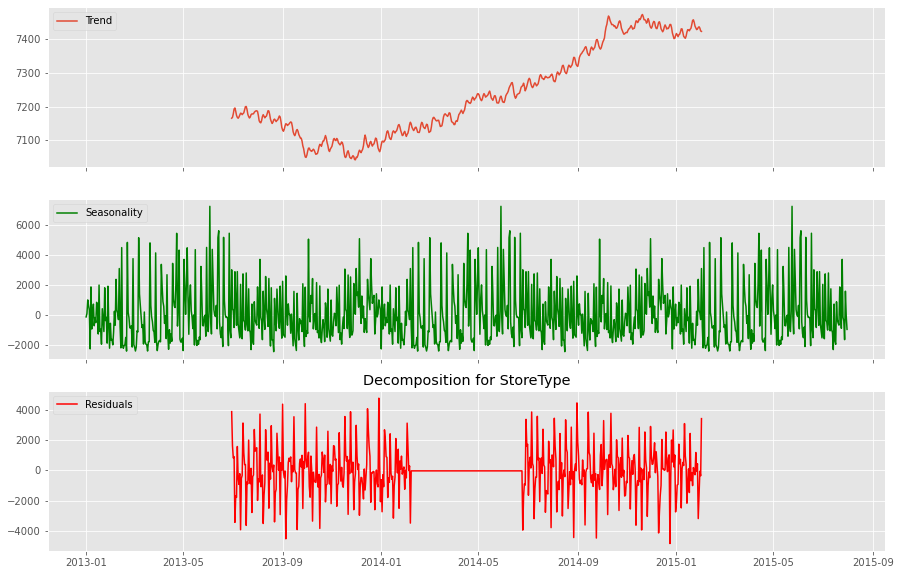

In [76]:
plot_timeseries(sales_b,'b')

<ipython-input-74-35302a60f4da>:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition= seasonal_decompose(sales, model = 'additive',freq=360)


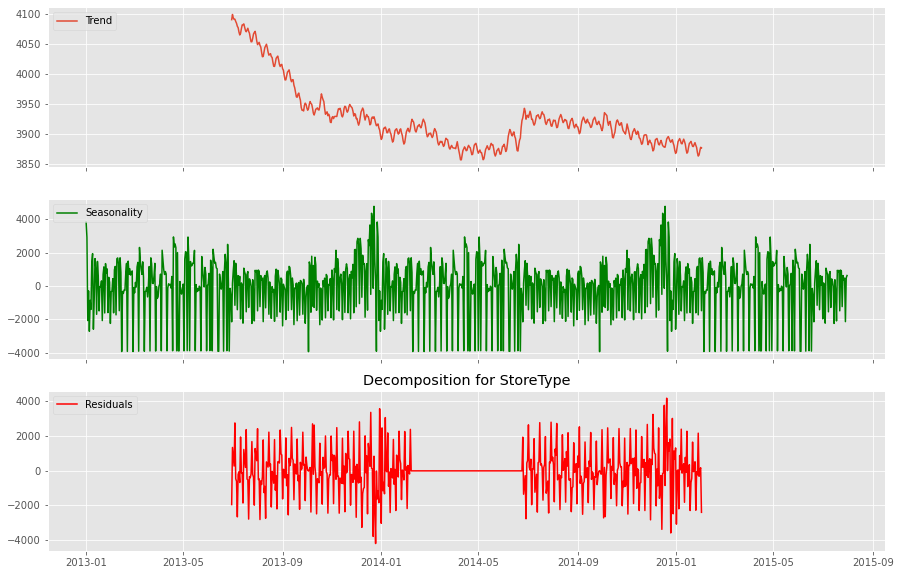

In [77]:
plot_timeseries(sales_c,'c')

<ipython-input-74-35302a60f4da>:7: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomposition= seasonal_decompose(sales, model = 'additive',freq=360)


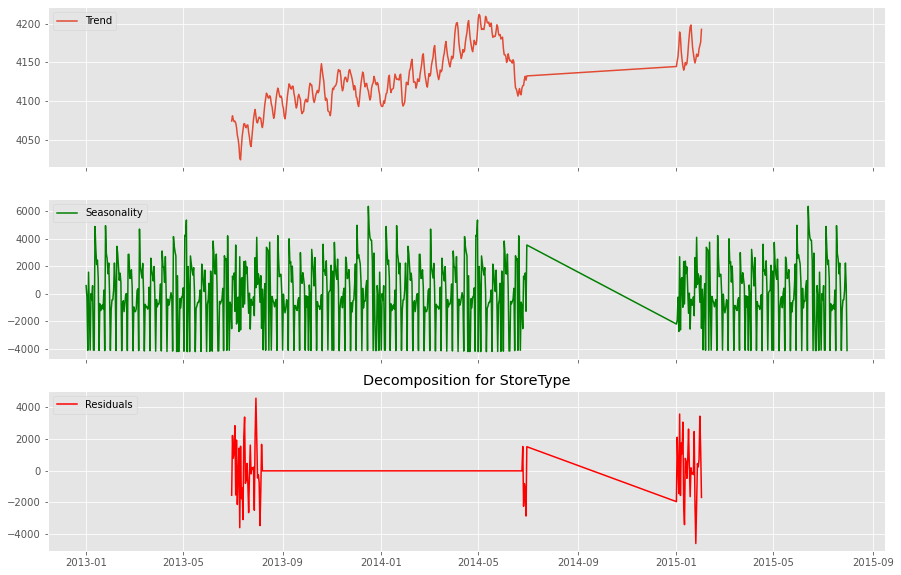

In [78]:
plot_timeseries(sales_d,'d')


Autocorrelation : Autocorrelation, also known as serial correlation or cross-autocorrelation, is the cross-correlation of a signal with itself at different points in time. It is the correlation between values of the process at different times. Informally, it is the similarity between observations as a function of the time lag between them. It is a mathematical tool for finding repeating patterns, such as the presence of a periodic signal obscured by noise.

Autocorrelation Function (ACF) : ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

Partial Autocorrelation Function (PACF) : PACF measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4.

In [79]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf,pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def auto_corr(sales):
    lag_acf = acf(sales,nlags=30)
    lag_pacf = pacf(sales,nlags=20,method='ols')
  
  
    plt.subplot(121)
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('ACF')


    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color ='red')
    plt.axhline(y=1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.axhline(y=-1.96/np.sqrt(len(sales_a)),linestyle='--',color ='red')
    plt.title('PACF')

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


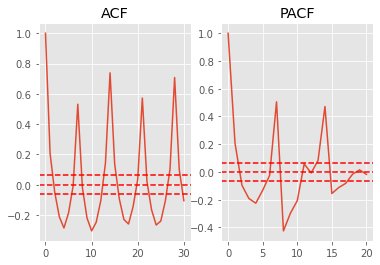

In [80]:
auto_corr(sales_a)

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


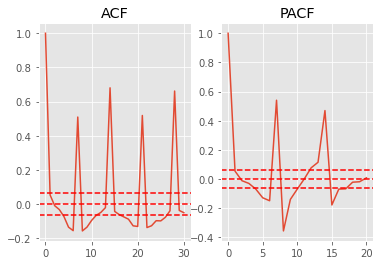

In [81]:
auto_corr(sales_b)

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


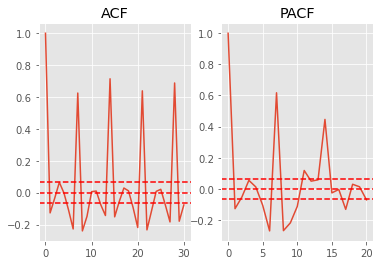

In [82]:
auto_corr(sales_c)

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:662: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


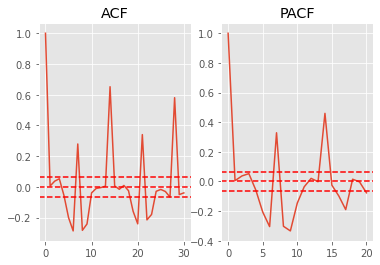

In [83]:
auto_corr(sales_d)

# 1) SARIMAX Model

In [84]:
import itertools  
import statsmodels.api as sm

In [85]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [86]:
def sample(sales):
  return(sales.resample('MS').mean())

In [87]:
y_sale_a = sample(sales_a)
y_sale_b = sample(sales_b)
y_sale_c = sample(sales_c)
y_sale_d = sample(sales_d)

In [88]:
def model(i,sale):
  ex = train2.loc[train2['Store'] == i,['Customers','Promo']]
#   ex = train2.loc[train2['Store'] == i]
#   ex.drop(['Open','PromoInterval','monthStr','Customers'],axis=1,inplace =True)
  y_sales = sale.resample('MS').mean()
  y_ex = ex.resample('MS').mean()
  exog = sm.add_constant(y_ex)
  exog.tail()
  return y_sales , exog

In [89]:
y_sale_model_a , exog_a = model(2,sales_a)
y_sale_model_b , exog_b = model(85,sales_b)
y_sale_model_c , exog_c = model(1,sales_c)
y_sale_model_d , exog_d = model(13,sales_d)

In [90]:
def model(i,sale):
  ex = train2.loc[train2['Store'] == i,['Customers','Promo']]
#   ex = train2.loc[train2['Store'] == i]
#   ex.drop(['Open','PromoInterval','monthStr','Customers'],axis=1,inplace =True)
  y_sales = sale.resample('MS').mean()
  y_ex = ex.resample('MS').mean()
  exog = sm.add_constant(y_ex)
  exog.tail()
  return y_sales , exog

In [91]:
y_sale_model_a , exog_a = model(2,sales_a)
y_sale_model_b , exog_b = model(85,sales_b)
y_sale_model_c , exog_c = model(1,sales_c)
y_sale_model_d , exog_d = model(13,sales_d)

In [92]:
exog_a = exog_a.dropna()
exog_a.isna().sum()

exog_b = exog_b.dropna()
exog_b.isna().sum()

exog_c = exog_c.dropna()
exog_c.isna().sum()

exog_d = exog_d.dropna()
exog_d.isna().sum()

const        0
Customers    0
Promo        0
dtype: int64

In [93]:
def arima(y_sale,exog,or1,sord):
    mod = sm.tsa.statespace.SARIMAX(y_sale,
                                    exog,
                                    order=or1,
                                    seasonal_order=sord,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)



    results = mod.fit(disp=0)
    ## -----------------------predictions-------------------
    pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), end=pd.to_datetime('2015-07-01'), dynamic=False)
    pred_ci = pred.conf_int()

   ##------------------------plot-----------------------------
    ax = y_sale['2013':].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

    ax.fill_between(pred_ci.index,
                      pred_ci.iloc[:, 1],
                      pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('sales')
    plt.legend()

    plt.show()


    y_forecasted = pred.predicted_mean
    y_truth = y_sale['2015-01-01':'2015-07-01']

   ##-------------Compute the mean square error----------------
    mse = ((y_forecasted - y_truth) ** 2).mean()
    rmse = np.sqrt(((y_forecasted - y_truth) ** 2).mean())
    rmspe =  np.sqrt(np.mean((y_forecasted/y_truth) ** 2))
    return results , mse,rmse,rmspe

## Prediction for Sales Store Type A

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


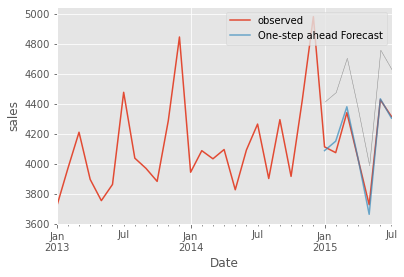

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   31
Model:             SARIMAX(5, 1, 3)x(1, 0, [], 12)   Log Likelihood                 -79.214
Date:                             Sat, 12 Jun 2021   AIC                            184.428
Time:                                     22:43:08   BIC                            191.773
Sample:                                 01-01-2013   HQIC                           182.919
                                      - 07-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019    491.178  -3.82e-06      1.000    -962.693     962.689
Customers      8.9598     4

In [94]:
or_a = (5,1,3)
sord_a=(1, 0, 0, 12)
result_a,mse_a,rmse_a,rmspe_a= arima(y_sale_model_a,exog_a,or_a,sord_a)
print(result_a.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_a, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_a, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_a, 2)))

## Prediction for Sales Store Type B

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


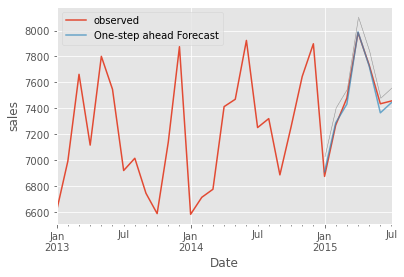

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   31
Model:             SARIMAX(3, 2, 3)x(1, 0, [], 12)   Log Likelihood                 -79.186
Date:                             Wed, 09 Jun 2021   AIC                            180.373
Time:                                     12:27:33   BIC                            187.402
Sample:                                 01-01-2013   HQIC                           179.722
                                      - 07-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0201   1.89e+04   1.06e-06      1.000   -3.71e+04    3.71e+04
Customers      7.0233      

In [95]:
or_b = (3,2,3)
sord_b=(1, 0, 0, 12)
result_b,mse_b,rmse_b,rmspe_b= arima(y_sale_model_b,exog_b,or_b,sord_b)
print(result_b.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_b, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_b, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_b, 2)))

## Prediction for Sales Store Type C

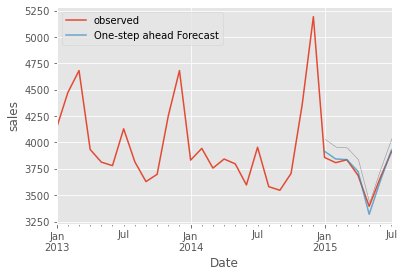

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   31
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                 -90.316
Date:                             Wed, 09 Jun 2021   AIC                            198.633
Time:                                     12:27:38   BIC                            205.586
Sample:                                 01-01-2013   HQIC                           198.989
                                      - 07-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0977   4316.016  -2.26e-05      1.000   -8459.334    8459.139
Customers      9.2331      

In [96]:
or_c = (2,1,2)
sord_c=(1, 0, 0, 12)
result_c,mse_c,rmse_c,rmspe_c= arima(y_sale_model_c,exog_c,or_c,sord_c)
print(result_c.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_c, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_c, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_c, 2)))

## Prediction for Sales Store Type D

C:\Users\Lenovo\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


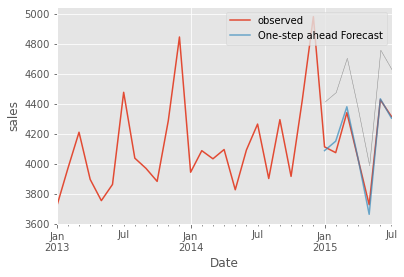

                                      SARIMAX Results                                      
Dep. Variable:                               Sales   No. Observations:                   31
Model:             SARIMAX(5, 1, 3)x(1, 0, [], 12)   Log Likelihood                 -79.214
Date:                             Sat, 12 Jun 2021   AIC                            184.428
Time:                                     22:49:22   BIC                            191.773
Sample:                                 01-01-2013   HQIC                           182.919
                                      - 07-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0019    491.178  -3.82e-06      1.000    -962.693     962.689
Customers      8.9598     4

In [96]:
or_d = (2,1,2)
sord_d=(1, 0, 0, 12)
result_d,mse_a,rmse_d,rmspe_d= arima(y_sale_model_d,exog_d,or_d,sord_d)
print(result_d.summary())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse_d, 2)))
print('The Root Squared Error of our forecasts is {}'.format(round(rmse_d, 2)))
print('The Root Squared Per Error of our forecasts is {}'.format(round(rmspe_d, 2)))

tried various combination of p,q,d in SARIMAX model and couldnot achieve RMPSE less than 1  therefore, moved to XGBoost model to improve model accuracy

# 2) XGBoost Model

In [224]:
!pip install xgboost
import xgboost as xgb

In [225]:
#Data splitting
train_xg = df_train_store.sort_values(['Date'],ascending = False)
ho_test = df_train_store[:6*7*1115]
ho_train = df_train_store[6*7*1115:]

In [226]:
#consider only data of Sales>0 and Open is 1
ho_test = ho_test[ho_test["Open"] != 0]
ho_test = ho_test[ho_test["Sales"] > 0]
ho_train = ho_train[ho_train["Open"] != 0]
ho_train = ho_train[ho_train["Sales"] > 0]

In [228]:
ho_train.drop(['Date','Open','PromoInterval'],axis=1,inplace =True)
ho_test.drop(['Date','Open','PromoInterval'],axis=1,inplace =True)
xtest =df_test_store.drop(['Date','Open','PromoInterval'],axis = 1)

In [229]:
#Create the training and testing dataset

ho_xtrain = ho_train.drop(['Sales'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['Sales'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

ho_xtrain = ho_train.drop(['StateHoliday'],axis=1 )
ho_ytrain = np.log1p(ho_train.Sales)
ho_xtest = ho_test.drop(['StateHoliday'],axis=1 )
ho_ytest = np.log1p(ho_test.Sales)

In [230]:
def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

In [231]:
dtrain = xgb.DMatrix(ho_xtrain, ho_ytrain)
dvalid = xgb.DMatrix(ho_xtest, ho_ytest)
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]


In [232]:
from time import time
params = {"objective": "reg:linear", #since it is a regression problem
          "booster" : "gbtree",     #tree
          "eta": 0.03,              #learning rate   to reduce overfitting issues
          "max_depth": 10,          #depth of the tree
          "subsample": 0.9,         #subsample the data prior to growing trees - overcomes overfitting
          "colsample_bytree": 0.7,  #subsampling of columns for each tree
          "silent": 1,              #verbosity
          "seed": 10                
          }
num_boost_round = 600           #countinue for 600 itertions


print("Train a XGBoost model")
start = time()
gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, 
  early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)
end = time()
print('Training time is {:2f} s.'.format(end-start))


print("validating")
ho_xtest.sort_index(inplace=True) 
ho_ytest.sort_index(inplace=True) 
yhat = gbm.predict(xgb.DMatrix(ho_xtest))
error = rmspe(np.expm1(ho_ytest), np.expm1(yhat))

print('RMSPE: {:.6f}'.format(error))

Train a XGBoost model
[16:36:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[16:36:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmse:8.02202	train-rmspe:0.99981	eval-rmse:7.98989	eval-rmspe:0.99981
[1]	train-rmse:7.78192	train-rmspe:0.99971	eval-rmse:7.74964	eval-rmspe:0.99971
[2]	train-rmse:7.54857	train-rmspe:0.99959	eval-rmse:7.51763	eval-rmspe:0.99959
[3]	train-rmse:7.32212	train-rmspe:0.99945	eval-rmse:7.29211	eval-rmspe:0.99945
[4]	train-rmse:7.10253	train-rmspe:0.99928	eval-rmse:7.07336	eval-rmspe:0.99927
[5]	train-rmse:

In [233]:
print('RMSPE: {:.6f}'.format(error))

RMSPE: 0.009342


In [234]:
df_predict = pd.DataFrame(yhat)
df_predict.head()

,0
0,8.560668
1,8.519476
2,8.469248
3,8.519843
4,8.713059


In [235]:
#Create a new dataframe having actual , predicted values , ratio , error and weight
# analysis by hold-out set
res = pd.DataFrame(data = ho_ytest)
res['Prediction']=yhat
res = pd.merge(ho_xtest,res, left_index= True, right_index=True)
#res['Ratio'] = res.Prediction/res.Sales
#res['Error'] =abs(res.Ratio-1)
#res['Weight'] = res.Sales/res.Prediction
res.head()

,Store,DayOfWeek,Year,Month,Customers,Promo,SchoolHoliday,Sales_x,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Sales/Customer,Sales_y,Prediction
0,1,5,2015,7,555,1,0,5263,0,0,1270.0,9.0,2008.0,0,0.0,0.0,9.482883,8.568646,8.560668
1,1,4,2015,7,546,1,0,5020,0,0,1270.0,9.0,2008.0,0,0.0,0.0,9.194139,8.521384,8.519476
2,1,3,2015,7,523,1,0,4782,0,0,1270.0,9.0,2008.0,0,0.0,0.0,9.143403,8.472823,8.469248
3,1,2,2015,7,560,1,0,5011,0,0,1270.0,9.0,2008.0,0,0.0,0.0,8.948214,8.519590,8.519843
4,1,1,2015,7,612,1,0,6102,0,0,1270.0,9.0,2008.0,0,0.0,0.0,9.970588,8.716536,8.713059



XGBoost model uses boosting technique to boost the weak learners and updates the weights to improve the model predictions.

Lets do some correction of the weights to improve our RMPSE score.

It can be seen that weight 0.995 gives 0.112 RMSe

weight correction
RMSPE for 0.990:0.084917
RMSPE for 0.991:0.076939
RMSPE for 0.992:0.068904
RMSPE for 0.993:0.060815
RMSPE for 0.994:0.052682
RMSPE for 0.995:0.044519
RMSPE for 0.996:0.036356
RMSPE for 0.997:0.028256
RMSPE for 0.998:0.020388
RMSPE for 0.999:0.013317
RMSPE for 1.000:0.009342
RMSPE for 1.001:0.012226
RMSPE for 1.002:0.019181
RMSPE for 1.003:0.027328
RMSPE for 1.004:0.035920
RMSPE for 1.005:0.044752
RMSPE for 1.006:0.053745
RMSPE for 1.007:0.062865
RMSPE for 1.008:0.072097
RMSPE for 1.009:0.081429
Best weight for Score:1.0    0.009342
dtype: float64


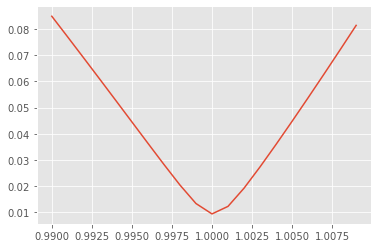

In [236]:
# whole correction
print("weight correction")
W=[(0.990+(i/1000)) for i in range(20)]
S =[]
for w in W:
    error = rmspe(np.expm1(ho_ytest), np.expm1(yhat*w))
    print('RMSPE for {:.3f}:{:.6f}'.format(w,error))
    S.append(error)
Score = pd.Series(S,index=W)
Score.plot()
BS = Score[Score.values == Score.values.min()]
print ('Best weight for Score:{}'.format(BS))

## User Interface

In [ ]:
import tkinter as tk
from tkinter import *

window = Tk()

window.title("Welcome to Sale Prediction app")

window.mainloop()

In [ ]:
## Partial output

from tkinter import *
from PIL import ImageTk,Image
root = Tk()
canvas = Canvas(root, width = 500, height = 500)
canvas.pack()
img = ImageTk.PhotoImage(Image.open("store_a.png"))
canvas.create_image(20, 20, anchor=NW, image=img)
root.mainloop()

In [1]:
import tkinter as tk

# --- functions ---
# `bind` sends `event` to function so it has to receive it
# `command=` doesn't sends `event` so it need some default value - ie. None
def on_button(event=None): 

    answer = entry.get().strip()

    if answer in ("Store A", "Store a","store A","store a","a","A"):
        label['text'] = "The Mean Squared Error=1751.29 \n The Root Squared Error=41.85 \n The Root Squared Per Error=1.0 \n predicted value=8.560".format(answer)
        
    elif answer in ("Store B", "Store b","store B","store b","b","B"):
        label['text'] = "The Mean Squared Error=1275.81 \n The Root Squared Error=35.72 \n The Root Squared Per Error=1.0 \n predicted value=8.519".format(answer)
    
    elif answer in ("Store C", "Store c","store C","store c","c","C"):
        label['text'] = "The Mean Squared Error=1854.64 \n The Root Squared Error=43.07 \n The Root Squared Per Error=1.0 \n predicted value=8.469".format(answer)  

    elif answer in ("Store D", "Store d","store D","store d","d","D"):
        label['text'] = "The Mean Squared Error=1651.67 \n The Root Squared Error=40.07 \n The Root Squared Per Error=1.0 \n predicted value=8.351".format(answer)  

    else:
        label['text'] = "{0}? What is {0}?".format(answer)

# --- main ---

root = tk.Tk()
root.geometry("300x300")
root.title("Rossmann Sales Prediction")

entry = tk.Entry(root)
entry.pack()

# run function when in `entry` you press `ENTER` on keyboard 
entry.bind('<Return>', on_button) 

button = tk.Button(root, text="Enter", command=on_button)
button.pack()

label = tk.Label(root)
label.pack()

# activate `entry` so you don't have to click in `entry` to start typing
entry.focus() 

root.mainloop()

In [97]:
from pandas import DataFrame

data3 = {'Interest_Rate': [5,5.5,6,5.5,5.25,6.5,7,8,7.5,8.5],
         'Stock_Index_Price': [1500,1520,1525,1523,1515,1540,1545,1560,1555,1565]
        }
df3 = DataFrame(data3,columns=['Interest_Rate','Stock_Index_Price'])
print (df3)


   Interest_Rate  Stock_Index_Price
0           5.00               1500
1           5.50               1520
2           6.00               1525
3           5.50               1523
4           5.25               1515
5           6.50               1540
6           7.00               1545
7           8.00               1560
8           7.50               1555
9           8.50               1565
